# Time Series Comparison of Tesla and General Motors Stock Value
 Learning and understanding how to do a time series analysis in Python using Facebook's Prophet package using additive models and visualizing the results with Matplotlib
 Based on the blog: https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [10]:
import quandl
import pandas as pd
quandl.ApiConfig.api_key = 'E2Q3yLVPHkRLqtbCh5Qq'
tesla=quandl.get('WIKI/TSLA')
gm=quandl.get('WIKI/GM')

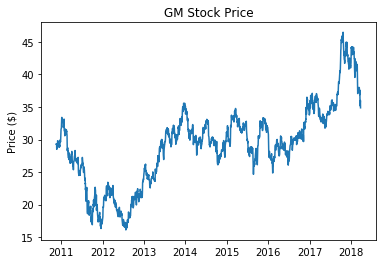

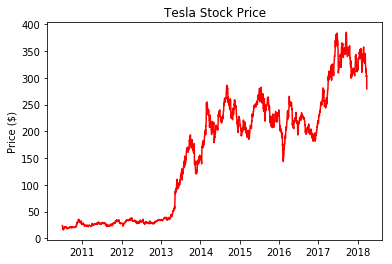

In [11]:
import matplotlib.pyplot as plt
plt.plot(gm.index,gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(tesla.index,tesla['Adj. Close'],color='red')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.show()

In [12]:
#Market cap= share price * number of shares
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010:1.50e9}

tesla['Year']=tesla.index.year

tesla.reset_index(level=0,inplace=True)
tesla['cap']=0

for i,year in enumerate(tesla['Year']):
    shares=tesla_shares.get(year)
    tesla.ix[i,'cap']=shares*tesla.ix[i,'Adj. Close']

gm['Year']=gm.index.year

gm.reset_index(level=0,inplace=True)
gm['cap']=0

for i,year in enumerate(gm['Year']):
    shares=gm_shares.get(year)
    gm.ix[i,'cap']=shares*gm.ix[i,'Adj. Close']
    

In [15]:
cars=gm.merge(tesla,how='inner',on='Date')
cars.rename(columns={'cap_x':'gm_cap','cap_y':'tesla_cap'},inplace=True)
cars=cars.ix[:,['Date','gm_cap','tesla_cap']]
#to get the market cap value in billions
cars['gm_cap']=cars['gm_cap']/1e9
cars['tesla_cap']=cars['tesla_cap']/1e9
cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


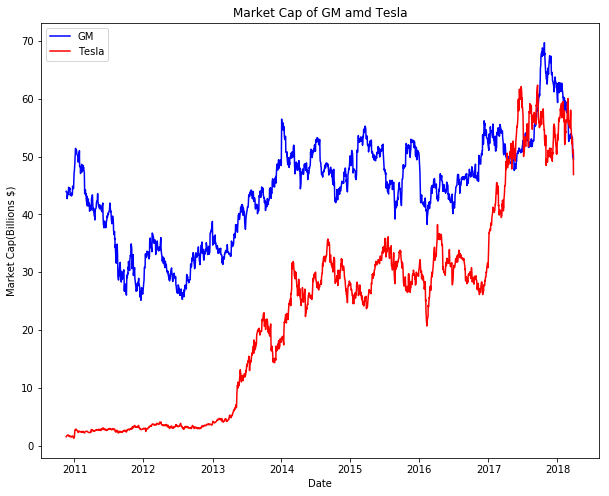

In [16]:
plt.figure(figsize=(10,8))
plt.plot(cars['Date'],cars['gm_cap'],'b-',label='GM')
plt.plot(cars['Date'],cars['tesla_cap'],'r-',label='Tesla')
plt.xlabel('Date');plt.ylabel('Market Cap(Billions $)');
plt.title('Market Cap of GM amd Tesla')
plt.legend();

In [18]:
import numpy as np
#Period during which Tesla had a higher value then GM
first_date=cars.ix[np.min(list(np.where(cars['tesla_cap']>cars['gm_cap'])[0])),'Date']
last_date=cars.ix[np.max(list(np.where(cars['tesla_cap']>cars['gm_cap'])[0])),'Date']
print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


# Prediction

In [22]:
import fbprophet

gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Convert value to billions
gm['y'] = gm['y'] / 1e9
#changepoint prior scale is to analyse how sensitive the trend is to changes
gm_prophet=fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(gm)

tesla = tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet=fbprophet.Prophet(changepoint_prior_scale=0.15)
tesla_prophet.fit(tesla)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
#Predicting
gm_forecast=gm_prophet.make_future_dataframe(periods=365*2,freq='D')
gm_forecast=gm_prophet.predict(gm_forecast)


tesla_forecast=tesla_prophet.make_future_dataframe(periods=365*2,freq='D')
tesla_forecast=tesla_prophet.predict(tesla_forecast)

Text(0.5,1,'Market Cap of GM')

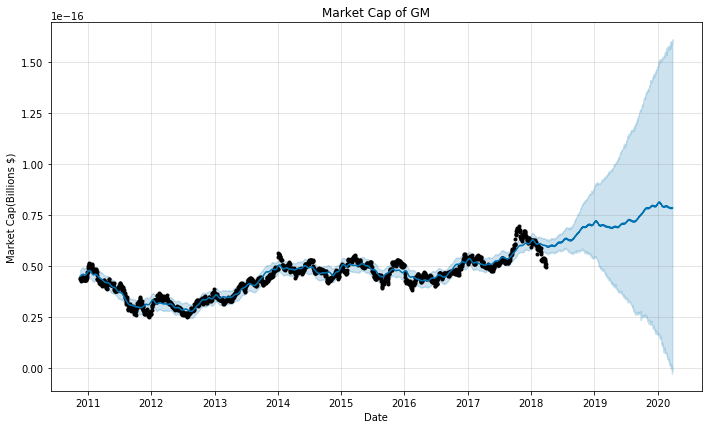

In [25]:
gm_prophet.plot(gm_forecast,xlabel='Date',ylabel='Market Cap(Billions $)')
plt.title('Market Cap of GM')

Text(0.5,1,'Market Cap of Tesla')

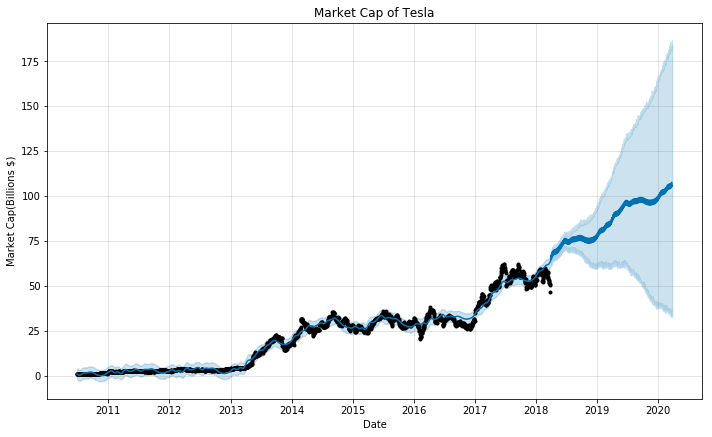

In [26]:
tesla_prophet.plot(tesla_forecast,xlabel='Date',ylabel='Market Cap(Billions $)')
plt.title('Market Cap of Tesla')

### Effect of Changepoint Prior Scale

In [28]:
for changepoint in [0.001,0.05,0.1,0.5]:
    model=fbprophet.Prophet(daily_seasonality=False,changepoint_prior_scale=changepoint)
    model.fit(tesla)
    prediction=model.make_future_dataframe(periods=365*2,freq='D')
    prediction=model.predict(prediction)
    tesla[changepoint]=prediction['yhat']

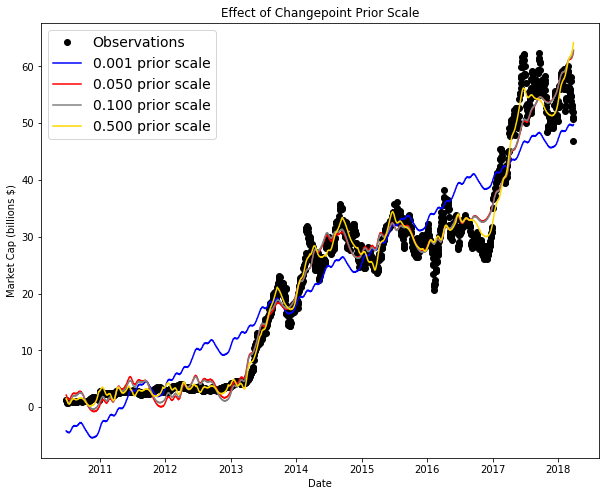

In [32]:
#Plot the chart
plt.figure(figsize=(10,8))
plt.plot(tesla['ds'],tesla['y'],'ko',label='Observations')
colors={0.001:'b',0.05: 'r', 0.1: 'grey', 0.5: 'gold'}
for changepoint in [0.001,0.05,0.1,0.5]:
    plt.plot(tesla['ds'],tesla[changepoint],color=colors[changepoint],label='%.3f prior scale' % changepoint)
    plt.legend(prop={'size':14})
    plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

In [33]:
gm_prophet.changepoints[:10]

59    2011-02-14
118   2011-05-10
177   2011-08-03
237   2011-10-27
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
592   2013-04-01
Name: ds, dtype: datetime64[ns]

To be updated...